In [1]:
import anndata as ad
import gc
import sys
from scipy.sparse import csc_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
import random
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import pickle
import heapq
import matplotlib
import os
# import umap
from sklearn.decomposition import PCA

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

batch_size = 50000
pred_start = 1
pred_end = 2

cuda


In [3]:
train_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod1.h5ad'
train_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod2.h5ad'
test_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod1.h5ad'
test_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod2.h5ad'

In [4]:
input_train_mod1 = ad.read_h5ad(train_mod1_file)
input_train_mod2 = ad.read_h5ad(train_mod2_file)
input_test_mod1 = ad.read_h5ad(test_mod1_file)
input_test_mod2 = ad.read_h5ad(test_mod2_file)

In [5]:
print(input_train_mod1)
print(input_train_mod2)
print(input_test_mod1)
print(input_test_mod2)

AnnData object with n_obs × n_vars = 66175 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 66175 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'


In [6]:
print(sorted(set(input_train_mod1.obs['batch'])))
print(sorted(set(input_train_mod2.obs['batch'])))

['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']
['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']


In [7]:
print(sorted(set(input_test_mod1.obs['batch'])))
print(sorted(set(input_test_mod2.obs['batch'])))

['s4d1', 's4d8', 's4d9']
['s4d1', 's4d8', 's4d9']


In [8]:
RNA_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :]
RNA_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :]
RNA_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :]
RNA_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :]
RNA_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :]
RNA_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :]

RNA_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :]
RNA_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :]
RNA_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :]

In [9]:
pro_s1d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d1", :]
pro_s1d2 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d2", :]
pro_s1d3 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d3", :]
pro_s2d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d1", :]
pro_s2d4 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d4", :]
pro_s2d5 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d5", :]

pro_s3d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d1", :]
pro_s3d6 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d6", :]
pro_s3d7 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d7", :]

In [10]:
RNA_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :]
RNA_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :]
RNA_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :]

In [11]:
pro_s4d1 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d1", :]
pro_s4d8 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d8", :]
pro_s4d9 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d9", :]

In [12]:
RNA_s1d1 = RNA_s1d1.X.toarray()
RNA_s1d2 = RNA_s1d2.X.toarray()
RNA_s1d3 = RNA_s1d3.X.toarray()
RNA_s2d1 = RNA_s2d1.X.toarray()
RNA_s2d4 = RNA_s2d4.X.toarray()
RNA_s2d5 = RNA_s2d5.X.toarray()

RNA_s3d1 = RNA_s3d1.X.toarray()
RNA_s3d6 = RNA_s3d6.X.toarray()
RNA_s3d7 = RNA_s3d7.X.toarray()

In [13]:
pro_s1d1 = pro_s1d1.X.toarray()[:, pred_start:pred_end]
pro_s1d2 = pro_s1d2.X.toarray()[:, pred_start:pred_end]
pro_s1d3 = pro_s1d3.X.toarray()[:, pred_start:pred_end]
pro_s2d1 = pro_s2d1.X.toarray()[:, pred_start:pred_end]
pro_s2d4 = pro_s2d4.X.toarray()[:, pred_start:pred_end]
pro_s2d5 = pro_s2d5.X.toarray()[:, pred_start:pred_end]

pro_s3d1 = pro_s3d1.X.toarray()[:, pred_start:pred_end]
pro_s3d6 = pro_s3d6.X.toarray()[:, pred_start:pred_end]
pro_s3d7 = pro_s3d7.X.toarray()[:, pred_start:pred_end]

In [14]:
RNA_s4d1 = RNA_s4d1.X.toarray()
RNA_s4d8 = RNA_s4d8.X.toarray()
RNA_s4d9 = RNA_s4d9.X.toarray()

In [15]:
pro_s4d1 = pro_s4d1.X.toarray()[:, pred_start:pred_end]
pro_s4d8 = pro_s4d8.X.toarray()[:, pred_start:pred_end]
pro_s4d9 = pro_s4d9.X.toarray()[:, pred_start:pred_end]

In [16]:
print(RNA_s1d1.shape)
print(pro_s1d1.shape)

(4721, 13953)
(4721, 1)


In [17]:
batch_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :].obs["batch"]
batch_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :].obs["batch"]
batch_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :].obs["batch"]
batch_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :].obs["batch"]
batch_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :].obs["batch"]
batch_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :].obs["batch"]

batch_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :].obs["batch"]
batch_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :].obs["batch"]
batch_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :].obs["batch"]

batch_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :].obs["batch"]
batch_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :].obs["batch"]
batch_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :].obs["batch"]

In [18]:
test_input = [RNA_s4d1, RNA_s4d8, RNA_s4d9]
test_output = [pro_s4d1, pro_s4d8, pro_s4d9]

test_input = np.concatenate(test_input, axis=0)
test_output = np.concatenate(test_output, axis=0)

In [19]:
print(test_input.shape)
print(test_output.shape)

(1000, 13953)
(1000, 1)


In [20]:
RNA_s1d1 = torch.from_numpy(RNA_s1d1)
RNA_s1d2 = torch.from_numpy(RNA_s1d2)
RNA_s1d3 = torch.from_numpy(RNA_s1d3)
RNA_s2d1 = torch.from_numpy(RNA_s2d1)
RNA_s2d4 = torch.from_numpy(RNA_s2d4)
RNA_s2d5 = torch.from_numpy(RNA_s2d5)
RNA_s3d1 = torch.from_numpy(RNA_s3d1)
RNA_s3d6 = torch.from_numpy(RNA_s3d6)
RNA_s3d7 = torch.from_numpy(RNA_s3d7)
RNA_s4d1 = torch.from_numpy(RNA_s4d1)
RNA_s4d8 = torch.from_numpy(RNA_s4d8)
RNA_s4d9 = torch.from_numpy(RNA_s4d9)

In [21]:
pro_s1d1 = torch.from_numpy(pro_s1d1)
pro_s1d2 = torch.from_numpy(pro_s1d2)
pro_s1d3 = torch.from_numpy(pro_s1d3)
pro_s2d1 = torch.from_numpy(pro_s2d1)
pro_s2d4 = torch.from_numpy(pro_s2d4)
pro_s2d5 = torch.from_numpy(pro_s2d5)
pro_s3d1 = torch.from_numpy(pro_s3d1)
pro_s3d6 = torch.from_numpy(pro_s3d6)
pro_s3d7 = torch.from_numpy(pro_s3d7)
pro_s4d1 = torch.from_numpy(pro_s4d1)
pro_s4d8 = torch.from_numpy(pro_s4d8)
pro_s4d9 = torch.from_numpy(pro_s4d9)

In [22]:
test_input = torch.from_numpy(test_input)
test_output = torch.from_numpy(test_output)

In [23]:
RNA_s1d1 = RNA_s1d1.float()
RNA_s1d2 = RNA_s1d2.float()
RNA_s1d3 = RNA_s1d3.float()
RNA_s2d1 = RNA_s2d1.float()
RNA_s2d4 = RNA_s2d4.float()
RNA_s2d5 = RNA_s2d5.float()
RNA_s3d1 = RNA_s3d1.float()
RNA_s3d6 = RNA_s3d6.float()
RNA_s3d7 = RNA_s3d7.float()
RNA_s4d1 = RNA_s4d1.float()
RNA_s4d8 = RNA_s4d8.float()
RNA_s4d9 = RNA_s4d9.float()

pro_s1d1 = pro_s1d1.float()
pro_s1d2 = pro_s1d2.float()
pro_s1d3 = pro_s1d3.float()
pro_s2d1 = pro_s2d1.float()
pro_s2d4 = pro_s2d4.float()
pro_s2d5 = pro_s2d5.float()
pro_s3d1 = pro_s3d1.float()
pro_s3d6 = pro_s3d6.float()
pro_s3d7 = pro_s3d7.float()
pro_s4d1 = pro_s4d1.float()
pro_s4d8 = pro_s4d8.float()
pro_s4d9 = pro_s4d9.float()

In [24]:
test_input = test_input.float()
test_output = test_output.float()

In [25]:
RNA_s1d1 = RNA_s1d1.to(device)
RNA_s1d2 = RNA_s1d2.to(device)
RNA_s1d3 = RNA_s1d3.to(device)
RNA_s2d1 = RNA_s2d1.to(device)
RNA_s2d4 = RNA_s2d4.to(device)
RNA_s2d5 = RNA_s2d5.to(device)
RNA_s3d1 = RNA_s3d1.to(device)
RNA_s3d6 = RNA_s3d6.to(device)
RNA_s3d7 = RNA_s3d7.to(device)
RNA_s4d1 = RNA_s4d1.to(device)
RNA_s4d8 = RNA_s4d8.to(device)
RNA_s4d9 = RNA_s4d9.to(device)

pro_s1d1 = pro_s1d1.to(device)
pro_s1d2 = pro_s1d2.to(device)
pro_s1d3 = pro_s1d3.to(device)
pro_s2d1 = pro_s2d1.to(device)
pro_s2d4 = pro_s2d4.to(device)
pro_s2d5 = pro_s2d5.to(device)
pro_s3d1 = pro_s3d1.to(device)
pro_s3d6 = pro_s3d6.to(device)
pro_s3d7 = pro_s3d7.to(device)
pro_s4d1 = pro_s4d1.to(device)
pro_s4d8 = pro_s4d8.to(device)
pro_s4d9 = pro_s4d9.to(device)

In [26]:
test_input = test_input.to(device)
test_output = test_output.to(device)

In [27]:
input_feature = RNA_s1d1.shape[1]
# output_feature = pred_num

In [28]:
# auto-encoder model
# base model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.linear1 = nn.Linear(input_feature, 4)
        self.linear2 = nn.Linear(input_feature//2, input_feature//4)
        self.linear3 = nn.Linear(input_feature//4, input_feature//8)
        self.linear4 = nn.Linear(input_feature//8, input_feature//16)
        
        self.linear5 = nn.Linear(4, 1)
        self.relu = nn.ReLU()
        self.leakyrelu = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(0.15)
        
        self.linear = nn.Linear(input_feature, 1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        
        output = self.linear5(x)
        
        return output.float()

In [29]:
PATH = 'No_norm_model_RNA_pro'

In [30]:
def fit(num_epochs, model, loss_fn, RNA, pro, i):
    train_ds = TensorDataset(RNA, pro)
    train_dl = DataLoader(train_ds, batch_size= batch_size, shuffle=True)
    val_best = float('inf')
    train_pred_output = []
    val_pred_output = []
    for epoch in range(num_epochs):
        for x,y in train_dl:
            model = model.train()
            pred = model(x)
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()
            opt.zero_grad()

        if epoch % 1999 == 0:
            model = model.eval()
            
            
            s1d1_pred = model(RNA_s1d1)
            s1d1_loss = loss_fn(s1d1_pred, pro_s1d1)
            s1d1_loss = torch.sqrt(s1d1_loss)
            s1d1_loss = s1d1_loss.cpu().detach().numpy()
            
            s1d2_pred = model(RNA_s1d2)
            s1d2_loss = loss_fn(s1d2_pred, pro_s1d2)
            s1d2_loss = torch.sqrt(s1d2_loss)
            s1d2_loss = s1d2_loss.cpu().detach().numpy()
            
            s1d3_pred = model(RNA_s1d3)
            s1d3_loss = loss_fn(s1d3_pred, pro_s1d3)
            s1d3_loss = torch.sqrt(s1d3_loss)
            s1d3_loss = s1d3_loss.cpu().detach().numpy()
            
            s2d1_pred = model(RNA_s2d1)
            s2d1_loss = loss_fn(s2d1_pred, pro_s2d1)
            s2d1_loss = torch.sqrt(s2d1_loss)
            s2d1_loss = s2d1_loss.cpu().detach().numpy()
            
            s2d4_pred = model(RNA_s2d4)
            s2d4_loss = loss_fn(s2d4_pred, pro_s2d4)
            s2d4_loss = torch.sqrt(s2d4_loss)
            s2d4_loss = s2d4_loss.cpu().detach().numpy()
            
            s2d5_pred = model(RNA_s2d5)
            s2d5_loss = loss_fn(s2d5_pred, pro_s2d5)
            s2d5_loss = torch.sqrt(s2d5_loss)
            s2d5_loss = s2d5_loss.cpu().detach().numpy()
            
            s3d1_pred = model(RNA_s3d1)
            s3d1_loss = loss_fn(s3d1_pred, pro_s3d1)
            s3d1_loss = torch.sqrt(s3d1_loss)
            s3d1_loss = s3d1_loss.cpu().detach().numpy()
            
            s3d6_pred = model(RNA_s3d6)
            s3d6_loss = loss_fn(s3d6_pred, pro_s3d6)
            s3d6_loss = torch.sqrt(s3d6_loss)
            s3d6_loss = s3d6_loss.cpu().detach().numpy()
            
            s3d7_pred = model(RNA_s3d7)
            s3d7_loss = loss_fn(s3d7_pred, pro_s3d7)
            s3d7_loss = torch.sqrt(s3d7_loss)
            s3d7_loss = s3d7_loss.cpu().detach().numpy()

            s4d1_pred = model(RNA_s4d1)
            s4d1_loss = loss_fn(s4d1_pred, pro_s4d1)
            s4d1_loss = torch.sqrt(s4d1_loss)
            s4d1_loss = s4d1_loss.cpu().detach().numpy()
            
            s4d8_pred = model(RNA_s4d8)
            s4d8_loss = loss_fn(s4d8_pred, pro_s4d8)
            s4d8_loss = torch.sqrt(s4d8_loss)
            s4d8_loss = s4d8_loss.cpu().detach().numpy()
            
            s4d9_pred = model(RNA_s4d9)
            s4d9_loss = loss_fn(s4d9_pred, pro_s4d9)
            s4d9_loss = torch.sqrt(s4d9_loss)
            s4d9_loss = s4d9_loss.cpu().detach().numpy()
            
            test_pred = model(test_input)
            test_loss = loss_fn(test_pred, test_output)
            test_loss = torch.sqrt(test_loss)
            test_loss = test_loss.cpu().detach().numpy()
            
            cal_test_loss = ((s4d1_loss**2*s4d1_pred.shape[0] + s4d8_loss**2*s4d8_pred.shape[0] + s4d9_loss**2*s4d9_pred.shape[0])/(s4d1_pred.shape[0]+s4d8_pred.shape[0]+s4d9_pred.shape[0]))**0.5
            
            losses[i, 0] = s1d1_loss
            losses[i, 1] = s1d2_loss
            losses[i, 2] = s1d3_loss
            losses[i, 3] = s2d1_loss
            losses[i, 4] = s2d4_loss
            losses[i, 5] = s2d5_loss
            losses[i, 6] = s3d1_loss
            losses[i, 7] = s3d6_loss
            losses[i, 8] = s3d7_loss
            losses[i, 9] = s4d1_loss
            losses[i, 10] = s4d8_loss
            losses[i, 11] = s4d9_loss
            
            print('Epoch ', epoch, 's1d1: ', s1d1_loss, 's1d2: ', s1d2_loss, 's1d3: ', s1d3_loss, 's2d1:', s2d1_loss, 's2d4:',
                  s2d4_loss, 's2d5:', s2d5_loss, 's3d1:', s3d1_loss, 's3d6:', s3d6_loss, 's3d7:', s3d7_loss, 's4d1:', s4d1_loss, 's4d8:', s4d8_loss, 's4d9:', s4d9_loss)
            
        if epoch == 1999:
            figure, ax = plt.subplots(1, 12, figsize = (30, 3))
            for i in range(1):
                ax[0].scatter(pro_s1d1.cpu().detach().numpy()[:, 0], s1d1_pred.cpu().detach().numpy()[:, 0], c='blue', s = 30, alpha=0.05)
                ax[0].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[0].set_title('s1d1 result')
                ax[0].set_xlabel('true')
                ax[0].set_ylabel('pred')

                ax[1].scatter(pro_s1d2.cpu().detach().numpy()[:, 0], s1d2_pred.cpu().detach().numpy()[:, 0], c='blue', s = 30, alpha=0.05)
                ax[1].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[1].set_title('s1d2 result')
                ax[1].set_xlabel('true')
                ax[1].set_ylabel('pred')

                ax[2].scatter(pro_s1d3.cpu().detach().numpy()[:, 0], s1d3_pred.cpu().detach().numpy()[:, 0], c='blue', s = 30, alpha=0.05)
                ax[2].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[2].set_title('s1d3 result')
                ax[2].set_xlabel('true')
                ax[2].set_ylabel('pred')
                
                ax[3].scatter(pro_s2d1.cpu().detach().numpy()[:, 0], s2d1_pred.cpu().detach().numpy()[:, 0], c='red', s = 30, alpha=0.05)
                ax[3].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[3].set_title('s2d1 result')
                ax[3].set_xlabel('true')
                ax[3].set_ylabel('pred')

                ax[4].scatter(pro_s2d4.cpu().detach().numpy()[:, 0], s2d4_pred.cpu().detach().numpy()[:, 0], c='red', s = 30, alpha=0.05)
                ax[4].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[4].set_title('s2d4 result')
                ax[4].set_xlabel('true')
                ax[4].set_ylabel('pred')

                ax[5].scatter(pro_s2d5.cpu().detach().numpy()[:, 0], s2d5_pred.cpu().detach().numpy()[:, 0], c='red', s = 30, alpha=0.05)
                ax[5].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[5].set_title('s2d5 result')
                ax[5].set_xlabel('true')
                ax[5].set_ylabel('pred')
                
                ax[6].scatter(pro_s3d1.cpu().detach().numpy()[:, 0], s3d1_pred.cpu().detach().numpy()[:, 0], c='orange', s = 30, alpha=0.05)
                ax[6].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[6].set_title('s3d1 result')
                ax[6].set_xlabel('true')
                ax[6].set_ylabel('pred')

                ax[7].scatter(pro_s3d6.cpu().detach().numpy()[:, 0], s3d6_pred.cpu().detach().numpy()[:, 0], c='orange', s = 30, alpha=0.05)
                ax[7].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[7].set_title('s3d6 result')
                ax[7].set_xlabel('true')
                ax[7].set_ylabel('pred')

                ax[8].scatter(pro_s3d7.cpu().detach().numpy()[:, 0], s3d7_pred.cpu().detach().numpy()[:, 0], c='orange', s = 30, alpha=0.05)
                ax[8].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[8].set_title('s3d7 result')
                ax[8].set_xlabel('true')
                ax[8].set_ylabel('pred')
                
                ax[9].scatter(pro_s4d1.cpu().detach().numpy()[:, 0], s4d1_pred.cpu().detach().numpy()[:, 0], c='green', s = 30, alpha=0.05)
                ax[9].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[9].set_title('s4d1 result')
                ax[9].set_xlabel('true')
                ax[9].set_ylabel('pred')

                ax[10].scatter(pro_s4d8.cpu().detach().numpy()[:, 0], s4d8_pred.cpu().detach().numpy()[:, 0], c='green', s = 30, alpha=0.05)
                ax[10].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[10].set_title('s4d8 result')
                ax[10].set_xlabel('true')
                ax[10].set_ylabel('pred')

                ax[11].scatter(pro_s4d9.cpu().detach().numpy()[:, 0], s4d9_pred.cpu().detach().numpy()[:, 0], c='green', s = 30, alpha=0.05)
                ax[11].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[11].set_title('s4d9 result')
                ax[11].set_xlabel('true')
                ax[11].set_ylabel('pred')
            
            plt.show()
    return

In [31]:
losses = np.zeros((12, 12))

In [32]:
RNAs = [RNA_s1d1, RNA_s1d2, RNA_s1d3, RNA_s2d1, RNA_s2d4, RNA_s2d5, RNA_s3d1, RNA_s3d6, RNA_s3d7, RNA_s4d1, RNA_s4d8, RNA_s4d9]
pros = [pro_s1d1, pro_s1d2, pro_s1d3, pro_s2d1, pro_s2d4, pro_s2d5, pro_s3d1, pro_s3d6, pro_s3d7, pro_s4d1, pro_s4d8, pro_s4d9]


Training model 0
Epoch  0 s1d1:  0.22112545 s1d2:  0.22524163 s1d3:  0.2569707 s2d1: 1.1989391 s2d4: 0.90773976 s2d5: 0.4420587 s3d1: 0.5612037 s3d6: 0.5158076 s3d7: 0.34240994 s4d1: 0.48026317 s4d8: 0.43929598 s4d9: 1.2782936
Epoch  1999 s1d1:  0.063363224 s1d2:  0.21040577 s1d3:  0.22678554 s2d1: 1.1218127 s2d4: 0.8232362 s2d5: 0.39141178 s3d1: 0.5141062 s3d6: 0.46139038 s3d7: 0.31231785 s4d1: 0.40742663 s4d8: 0.3510637 s4d9: 1.1625121


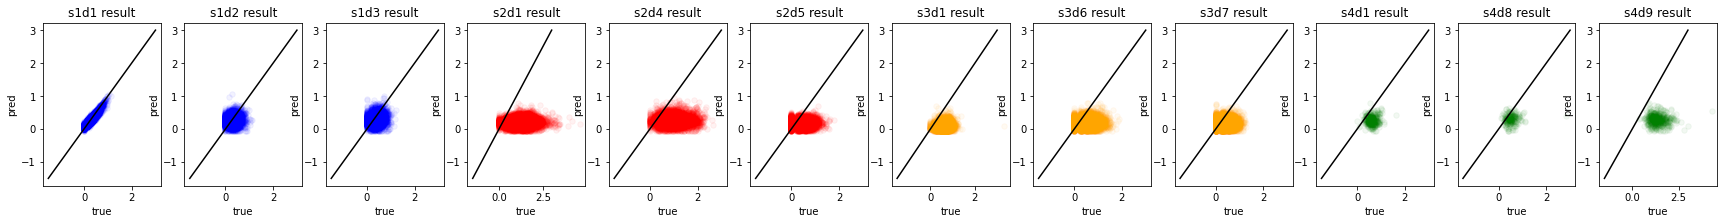


Training model 1
Epoch  0 s1d1:  0.22159953 s1d2:  0.22226621 s1d3:  0.25670204 s2d1: 1.197185 s2d4: 0.9067154 s2d5: 0.43781537 s3d1: 0.56039155 s3d6: 0.51219195 s3d7: 0.33877942 s4d1: 0.47540706 s4d8: 0.43421343 s4d9: 1.2724867
Epoch  1999 s1d1:  0.22028984 s1d2:  0.05612105 s1d3:  0.22304618 s2d1: 1.0962471 s2d4: 0.81447715 s2d5: 0.377807 s3d1: 0.49155873 s3d6: 0.44888753 s3d7: 0.29583672 s4d1: 0.37579152 s4d8: 0.32385412 s4d9: 1.1537553


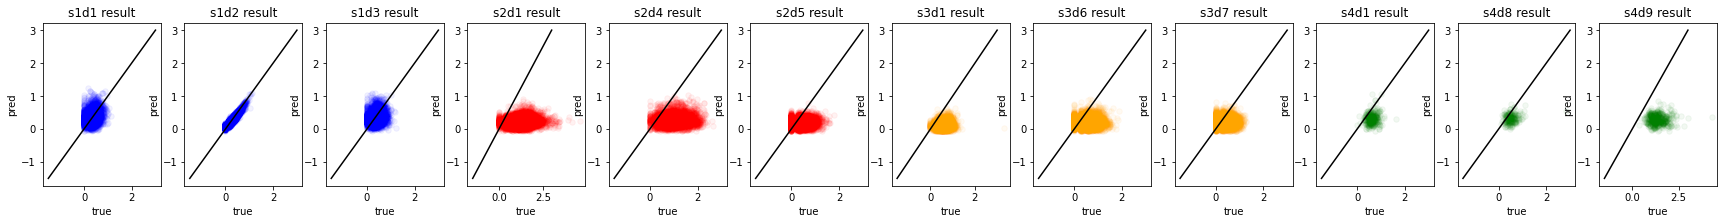


Training model 2
Epoch  0 s1d1:  0.21401268 s1d2:  0.21612217 s1d3:  0.24579173 s2d1: 1.1871004 s2d4: 0.89454395 s2d5: 0.4330473 s3d1: 0.5536471 s3d6: 0.50524235 s3d7: 0.33493078 s4d1: 0.4649489 s4d8: 0.42537194 s4d9: 1.260339
Epoch  1999 s1d1:  0.22592673 s1d2:  0.21559733 s1d3:  0.082163 s2d1: 1.0647917 s2d4: 0.7695744 s2d5: 0.37010172 s3d1: 0.46444368 s3d6: 0.4281972 s3d7: 0.29208106 s4d1: 0.36103204 s4d8: 0.30908746 s4d9: 1.0828048


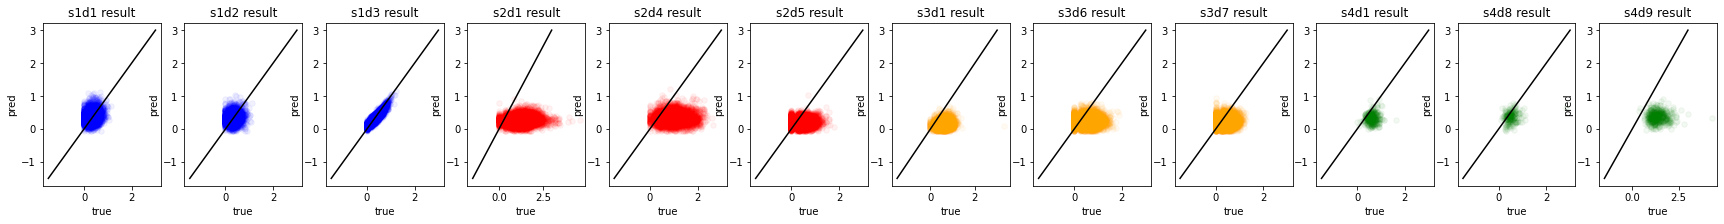


Training model 3
Epoch  0 s1d1:  0.28507197 s1d2:  0.28244963 s1d3:  0.25703532 s2d1: 0.97832406 s2d4: 0.6610848 s2d5: 0.31152815 s3d1: 0.4231162 s3d6: 0.3496481 s3d7: 0.26241195 s4d1: 0.2435653 s4d8: 0.26887262 s4d9: 0.96330136
Epoch  1999 s1d1:  1.4074274 s1d2:  1.3208171 s1d3:  1.3331494 s2d1: 0.267509 s2d4: 0.86163354 s2d5: 0.80882144 s3d1: 0.39190197 s3d6: 0.8315144 s3d7: 0.9490678 s4d1: 1.0341982 s4d8: 1.1810207 s4d9: 0.6942049


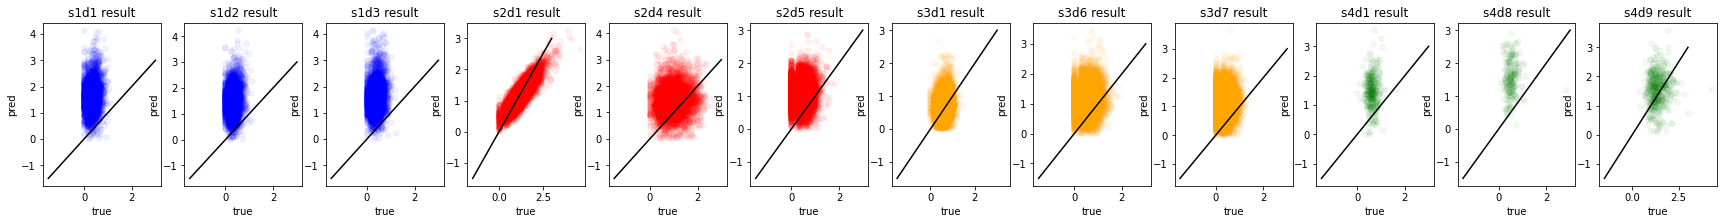


Training model 4
Epoch  0 s1d1:  0.28120464 s1d2:  0.2761515 s1d3:  0.2518653 s2d1: 0.9904051 s2d4: 0.6592379 s2d5: 0.31414497 s3d1: 0.4314163 s3d6: 0.35419562 s3d7: 0.26134112 s4d1: 0.2466404 s4d8: 0.26728937 s4d9: 0.9722125
Epoch  1999 s1d1:  1.019165 s1d2:  0.91770005 s1d3:  0.87600327 s2d1: 0.7026764 s2d4: 0.10925935 s2d5: 0.5275441 s3d1: 0.3164197 s3d6: 0.52010924 s3d7: 0.65611875 s4d1: 0.64903337 s4d8: 0.7771071 s4d9: 0.6633067


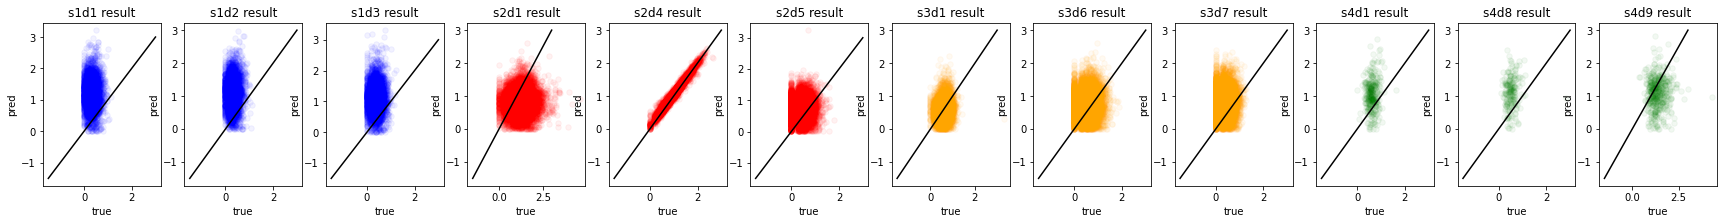


Training model 5
Epoch  0 s1d1:  0.21448292 s1d2:  0.21297055 s1d3:  0.24706884 s2d1: 1.1799526 s2d4: 0.8899117 s2d5: 0.42213306 s3d1: 0.549001 s3d6: 0.49611974 s3d7: 0.3247942 s4d1: 0.45597482 s4d8: 0.4163494 s4d9: 1.2504307
Epoch  1999 s1d1:  0.57261306 s1d2:  0.48888162 s1d3:  0.47526738 s2d1: 0.87244433 s2d4: 0.5864646 s2d5: 0.16452117 s3d1: 0.42285833 s3d6: 0.3908459 s3d7: 0.3419659 s4d1: 0.32738954 s4d8: 0.4184029 s4d9: 0.8974972


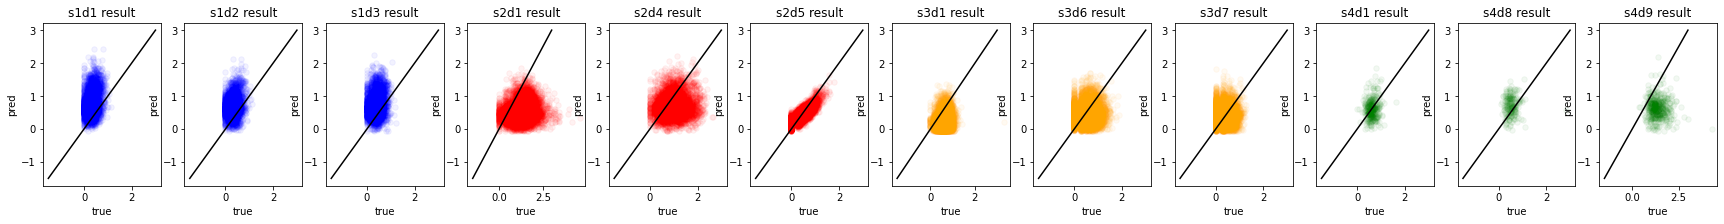


Training model 6
Epoch  0 s1d1:  0.22303732 s1d2:  0.22589861 s1d3:  0.2574167 s2d1: 1.1940156 s2d4: 0.907847 s2d5: 0.43758264 s3d1: 0.5553297 s3d6: 0.5115446 s3d7: 0.3385264 s4d1: 0.47907513 s4d8: 0.4395118 s4d9: 1.2757771
Epoch  1999 s1d1:  0.79726833 s1d2:  0.83834356 s1d3:  0.74447715 s2d1: 0.6194764 s2d4: 0.496166 s2d5: 0.49709088 s3d1: 0.15778406 s3d6: 0.50779873 s3d7: 0.6153814 s4d1: 0.53618217 s4d8: 0.72343045 s4d9: 0.46396178


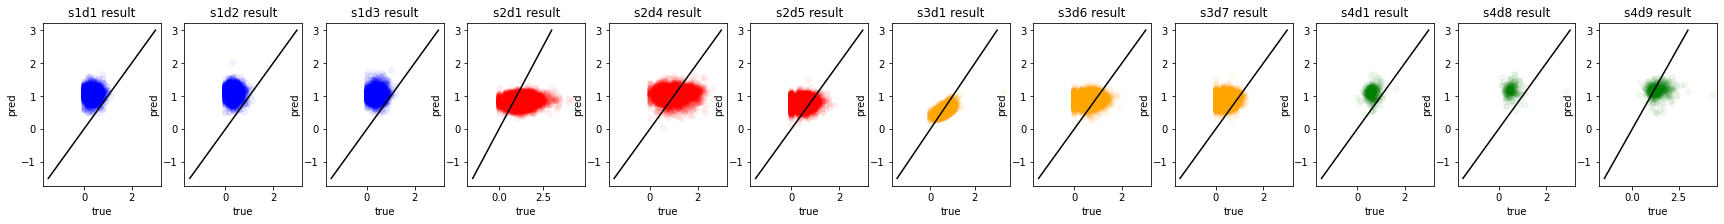


Training model 7
Epoch  0 s1d1:  0.19879225 s1d2:  0.19676036 s1d3:  0.22446974 s2d1: 1.1485257 s2d4: 0.8500252 s2d5: 0.40051144 s3d1: 0.5296697 s3d6: 0.467861 s3d7: 0.3040908 s4d1: 0.4157229 s4d8: 0.37808815 s4d9: 1.2047341
Epoch  1999 s1d1:  0.4908699 s1d2:  0.46401316 s1d3:  0.4385928 s2d1: 0.8474529 s2d4: 0.5923873 s2d5: 0.35914454 s3d1: 0.32686725 s3d6: 0.18646224 s3d7: 0.3548167 s4d1: 0.31715468 s4d8: 0.3888122 s4d9: 0.8210474


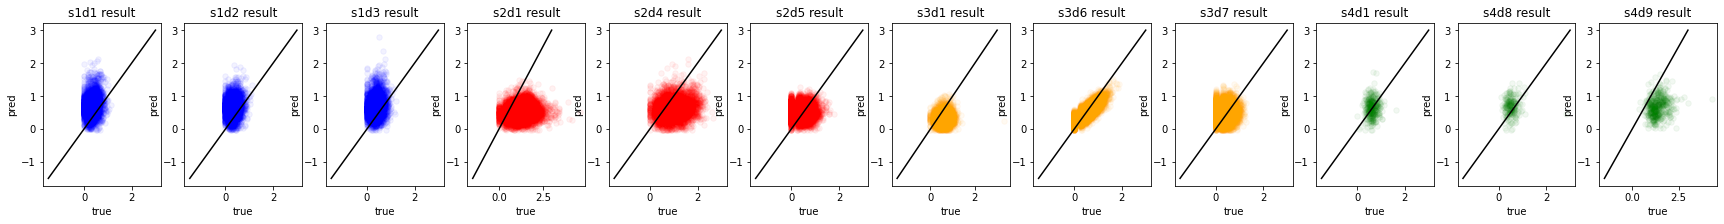


Training model 8
Epoch  0 s1d1:  0.22165288 s1d2:  0.22269633 s1d3:  0.25791225 s2d1: 1.1937382 s2d4: 0.90334976 s2d5: 0.43386528 s3d1: 0.55707306 s3d6: 0.508215 s3d7: 0.3325583 s4d1: 0.47446448 s4d8: 0.43285292 s4d9: 1.2721643
Epoch  1999 s1d1:  0.2692378 s1d2:  0.27480003 s1d3:  0.25496835 s2d1: 1.0421597 s2d4: 0.7542841 s2d5: 0.33790088 s3d1: 0.4265724 s3d6: 0.38801828 s3d7: 0.16999388 s4d1: 0.3544451 s4d8: 0.31969258 s4d9: 1.0469207


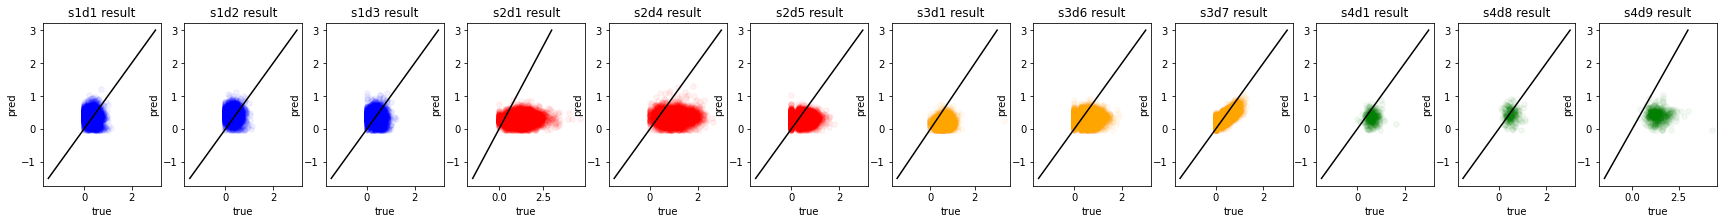


Training model 9
Epoch  0 s1d1:  0.20027924 s1d2:  0.19707355 s1d3:  0.20444459 s2d1: 1.0906218 s2d4: 0.77798575 s2d5: 0.3617303 s3d1: 0.49544516 s3d6: 0.4202055 s3d7: 0.2747353 s4d1: 0.33661354 s4d8: 0.31194678 s4d9: 1.1118208
Epoch  1999 s1d1:  0.3542616 s1d2:  0.36222407 s1d3:  0.31277725 s2d1: 0.9262015 s2d4: 0.597038 s2d5: 0.30265772 s3d1: 0.38385984 s3d6: 0.32665265 s3d7: 0.27557033 s4d1: 0.00016025337 s4d8: 0.2909127 s4d9: 0.8538899


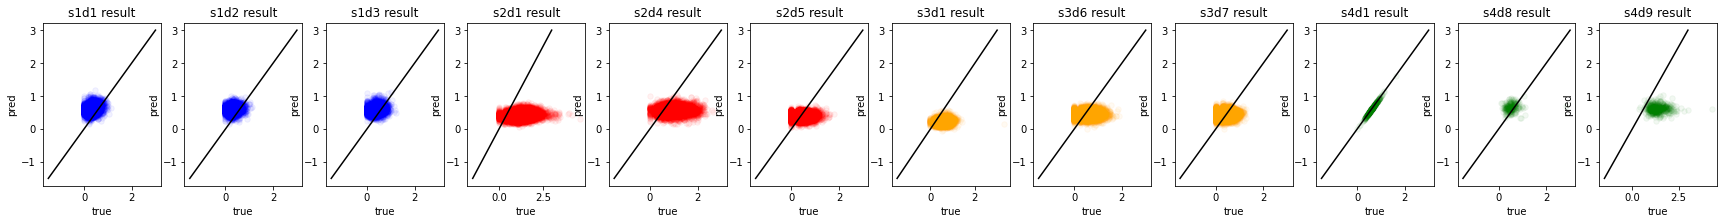


Training model 10
Epoch  0 s1d1:  0.19515036 s1d2:  0.1924419 s1d3:  0.20660856 s2d1: 1.1092867 s2d4: 0.7986534 s2d5: 0.37314326 s3d1: 0.5075063 s3d6: 0.434348 s3d7: 0.28220156 s4d1: 0.3581141 s4d8: 0.32491004 s4d9: 1.1371754
Epoch  1999 s1d1:  0.34929496 s1d2:  0.29079747 s1d3:  0.32362303 s2d1: 0.97409403 s2d4: 0.633966 s2d5: 0.3129522 s3d1: 0.41789225 s3d6: 0.3573288 s3d7: 0.2612873 s4d1: 0.26652724 s4d8: 0.00019535457 s4d9: 0.93549037


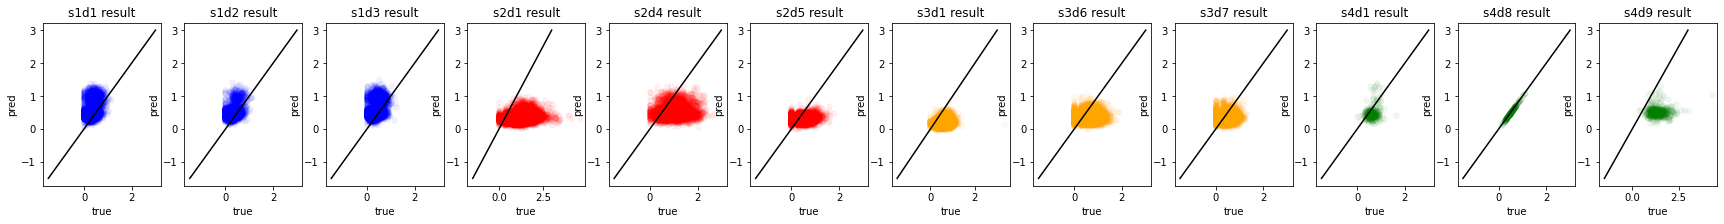


Training model 11
Epoch  0 s1d1:  0.4773636 s1d2:  0.4985145 s1d3:  0.43121916 s2d1: 0.8489683 s2d4: 0.54108596 s2d5: 0.31981936 s3d1: 0.3500238 s3d6: 0.32455269 s3d7: 0.33568388 s4d1: 0.26452443 s4d8: 0.39003682 s4d9: 0.7345473
Epoch  1999 s1d1:  0.9584598 s1d2:  0.97639704 s1d3:  0.9638952 s2d1: 0.57338107 s2d4: 0.5348195 s2d5: 0.65276504 s3d1: 0.24669592 s3d6: 0.5843201 s3d7: 0.6412165 s4d1: 0.70669055 s4d8: 0.86291283 s4d9: 0.00062989886


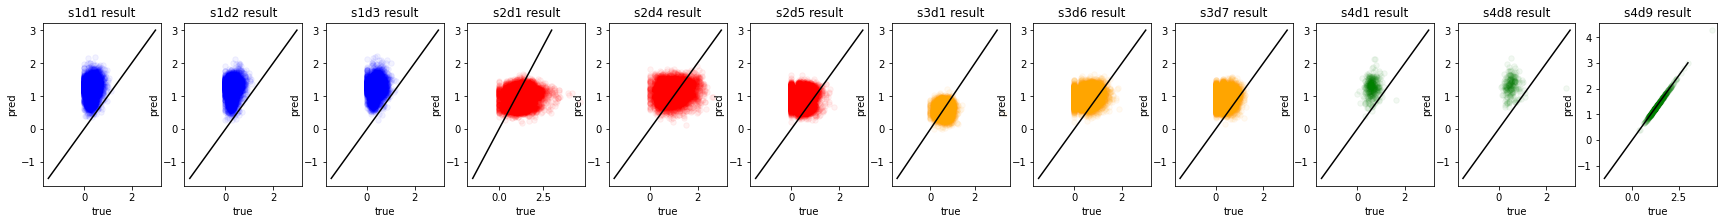

In [33]:
for i in range(12):
    print()
    print(f'Training model {i}')
    num_epochs = 2000
    learning_rate = 0.001
    latent_dim = 50
    loss_fn = F.mse_loss
    batch_size = 50000

    def seed_everything(seed=1234):
        random.seed(seed)
        os.environ['PYTHONHASHSEED'] = str(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.backends.cudnn.deterministic = True

    seed_everything()

    model = Autoencoder()
    # model.load_state_dict(torch.load('Batch_feature_norm_model'))
    model = model.to(device)
    opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    fit(num_epochs, model, loss_fn, RNAs[i], pros[i], i)

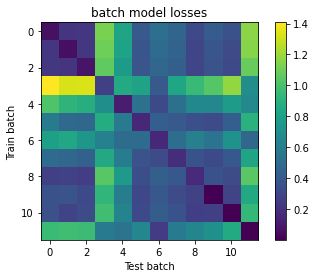

In [34]:
plt.imshow(losses)
plt.title('batch model losses')
plt.xlabel('Test batch')
plt.ylabel('Train batch')
plt.colorbar()
plt.show()

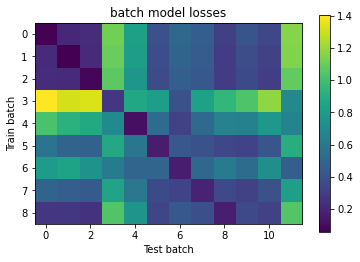

In [35]:
plt.imshow(losses[:-3, ])
plt.title('batch model losses')
plt.xlabel('Test batch')
plt.ylabel('Train batch')
plt.colorbar()
plt.show()

In [37]:
filehandler = open( 'emb_4_losses.pickle', "wb")
pickle.dump(losses, filehandler)
filehandler.close()

array([[6.33632243e-02, 2.10405767e-01, 2.26785541e-01, 1.12181270e+00,
        8.23236227e-01, 3.91411781e-01, 5.14106214e-01, 4.61390376e-01,
        3.12317848e-01, 4.07426625e-01, 3.51063699e-01, 1.16251206e+00],
       [2.20289841e-01, 5.61210513e-02, 2.23046184e-01, 1.09624708e+00,
        8.14477146e-01, 3.77806991e-01, 4.91558731e-01, 4.48887527e-01,
        2.95836717e-01, 3.75791520e-01, 3.23854119e-01, 1.15375531e+00],
       [2.25926727e-01, 2.15597332e-01, 8.21629986e-02, 1.06479168e+00,
        7.69574404e-01, 3.70101720e-01, 4.64443684e-01, 4.28197205e-01,
        2.92081058e-01, 3.61032039e-01, 3.09087455e-01, 1.08280480e+00],
       [1.40742743e+00, 1.32081711e+00, 1.33314943e+00, 2.67509013e-01,
        8.61633539e-01, 8.08821440e-01, 3.91901970e-01, 8.31514418e-01,
        9.49067771e-01, 1.03419816e+00, 1.18102074e+00, 6.94204926e-01],
       [1.01916504e+00, 9.17700052e-01, 8.76003265e-01, 7.02676415e-01,
        1.09259352e-01, 5.27544081e-01, 3.16419691e-01, 5.20